In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import json

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from google.colab import files
uploaded = files.upload()

Saving updated_X_recommend.pkl to updated_X_recommend.pkl
Saving updated_X_test.pkl to updated_X_test.pkl
Saving updated_X_train.pkl to updated_X_train.pkl
Saving updated_y_test.pkl to updated_y_test.pkl
Saving updated_y_train.pkl to updated_y_train.pkl


In [6]:
# Load the data
X_train = pd.read_pickle('updated_X_train.pkl')
y_train = pd.read_pickle('updated_y_train.pkl')
X_test = pd.read_pickle('updated_X_test.pkl')
y_test = pd.read_pickle('updated_y_test.pkl')
X_recommend = pd.read_pickle('updated_X_recommend.pkl')

In [7]:
X_train.head()

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,genre_modern indie pop,genre_modern rock,genre_nashville indie,genre_new romantic,genre_nz folk,genre_permanent wave,genre_pop,genre_pop punk,genre_pop rock,genre_shimmer pop
5430,175093.0,0.143,0.2690,10.0,-17.614,1.0,0.0351,0.290,0.859000,0.152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1349,141062.0,0.106,0.0202,8.0,-32.719,1.0,0.0430,0.799,0.769000,0.109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1754,210253.0,0.417,0.6890,2.0,-8.302,0.0,0.1780,0.575,0.000000,0.496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7103,333329.0,0.499,0.5830,9.0,-6.628,0.0,0.2100,0.227,0.000000,0.103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4726,168854.0,0.828,0.3330,4.0,-10.351,0.0,0.0332,0.732,0.000526,0.117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Load the data

### Normalize the Data with Min-Max Normalization

Since Stochastic Gradient Descent is based on Gradient Descent which is sensitive to range of features.
Features that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus all input features are normalized to the range [0,1]

In [8]:
# Normalize features to [0,1]
minmax_scaler = MinMaxScaler()
X_train = pd.DataFrame(minmax_scaler.fit_transform(X_train), columns=X_train.columns)

In [9]:
X_train.head()

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,genre_modern indie pop,genre_modern rock,genre_nashville indie,genre_new romantic,genre_nz folk,genre_permanent wave,genre_pop,genre_pop punk,genre_pop rock,genre_shimmer pop
0,0.044912,0.148187,0.268478,0.909091,0.608825,1.0,0.036449,0.291164,0.862450,0.137400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.035560,0.109845,0.019160,0.727273,0.258783,1.0,0.044652,0.802209,0.772088,0.093243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.054573,0.432124,0.689354,0.181818,0.824620,0.0,0.184839,0.577309,0.000000,0.490655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.088393,0.517098,0.583133,0.818182,0.863413,0.0,0.218069,0.227911,0.000000,0.087082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.043197,0.858031,0.332612,0.363636,0.777137,0.0,0.034476,0.734939,0.000528,0.101458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Hyperparameter Tuning
Tuning for:
- Loss function to be used(loss)
- Learning rate (learning_rate)

In [10]:
# Check accuracy for each value for each hyperparameter in its range
# We will use GridSearchCV to automate this process

loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']


#Convert to dictionary
hyperparameters = dict(loss=loss, learning_rate=learning_rate)

print(hyperparameters)

{'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']}


In [11]:
# estimator = ML model to be tested
# param_grid = dictionary of hyperparameters to be tested
# n_jobs = number of cores to be used in parallel, -1 means use all
# cv = number of cross validation set elements
# verbose = setting it to 2 will print updates to the terminal

best_model = GridSearchCV(estimator=SGDClassifier(eta0=0.01),
                         param_grid=hyperparameters,
                         n_jobs=-1,
                         cv=10,
                         verbose=2)

# Fit the model
best_model = best_model.fit(X_train,y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 891, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-pack

In [12]:
loss = best_model.best_estimator_.get_params()['loss']
learning_rate = best_model.best_estimator_.get_params()['learning_rate']

print(f'Best loss: {loss}')
print(f'Best learning_rate: {learning_rate}')

Best loss: hinge
Best learning_rate: constant


## Model

In [13]:
# model
stochastic_gradient_descent = SGDClassifier(loss=loss,
                                           learning_rate=learning_rate,
                                           eta0=0.01)

# fit the model
stochastic_gradient_descent.fit(X_train, y_train)

# prediction
predictions = stochastic_gradient_descent.predict(X_test)

### Visualize confusion matrix

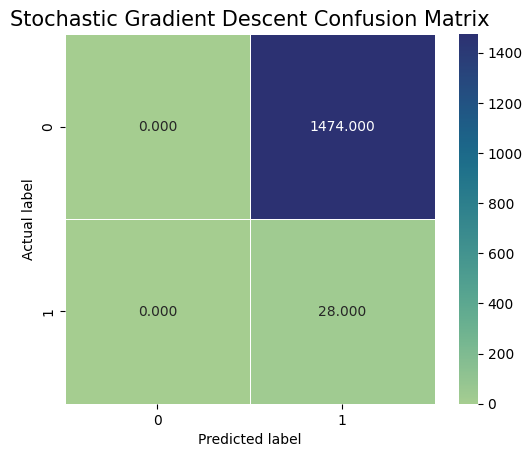

In [14]:
cm = confusion_matrix(y_test, predictions)
plt.figure()
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'crest');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Stochastic Gradient Descent Confusion Matrix', size = 15);
plt.show()

### Results

In [15]:
precision_macro_average = precision_score(y_test, predictions, average='macro')
precision_weighted_average = precision_score(y_test, predictions, average='weighted')

recall_macro_average = recall_score(y_test, predictions, average='macro')
recall_weighted_average = recall_score(y_test, predictions, average='weighted')

f1_macro_average = f1_score(y_test, predictions, average='macro')
f1_weighted_average = f1_score(y_test, predictions, average='weighted')


print(f'Precision (macro average)--> {round(precision_macro_average*100, 2)}%')
print(f'Precision (weighted average)--> {round(precision_weighted_average*100, 2)}%')

print(f'Recall (macro average)--> {round(recall_macro_average*100, 2)}%')
print(f'Recall (weighted average)--> {round(recall_weighted_average*100, 2)}%')

print(f'F1 score (macro average)--> {round(f1_macro_average*100, 2)}%')
print(f'F1 score (weighted average)--> {round(f1_weighted_average*100, 2)}%')

Precision (macro average)--> 0.93%
Precision (weighted average)--> 0.03%
Recall (macro average)--> 50.0%
Recall (weighted average)--> 1.86%
F1 score (macro average)--> 1.83%
F1 score (weighted average)--> 0.07%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1474
           1       0.02      1.00      0.04        28

    accuracy                           0.02      1502
   macro avg       0.01      0.50      0.02      1502
weighted avg       0.00      0.02      0.00      1502



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# File path on Google Drive
file_path = "/content/drive/MyDrive/year 29/Data Science /notebooks/spotify/model/f1_scores.json"

In [18]:
# Serialize f1 scores into a json file for later comparison between all models
model_name = "updated_stochastic_gradient_descent"
entry = {"f1_macro_average":f1_macro_average, "f1_weighted_average":f1_weighted_average}


with open(file_path, "r") as file:
    data = json.load(file)
data[model_name] = entry
with open(file_path, "w") as file:
    json.dump(data, file, indent=4)